In [1]:
import numpy as np
import torch.nn as nn 
from torchinfo import summary 
from torch.utils.data import DataLoader, Dataset 
from sklearn.metrics import accuracy_score 
import random 
import torch 
import matplotlib.pyplot as plt

### Loading Data

In [3]:
data = np.load('D:\Vanessa\Documents\eeg_data\processed_eeg_data.npz')
# data = np.load("D:\Vanessa\Documents\eeg_data\denoised_eeg_data.npz")
X_train = data['X_train']
X_val = data['X_val']
y_train = data['y_train']
y_val = data['y_val']

<>:1: SyntaxWarning: invalid escape sequence '\V'
<>:1: SyntaxWarning: invalid escape sequence '\V'
C:\Users\Vanessa\AppData\Local\Temp\ipykernel_2748\3682215561.py:1: SyntaxWarning: invalid escape sequence '\V'
  data = np.load('D:\Vanessa\Documents\eeg_data\processed_eeg_data.npz')


In [ ]:
# Change data structure to tensor
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

        # Calculate weights (4:1 downsampling ratio)
        self.weights = torch.where(self.y == 1,
                                   torch.tensor(4.0),   # seizure samples
                                   torch.tensor(1.0))   # non- seizure samples

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.weights[idx]

### Models 

In [4]:
class CNNLSTM1(nn.Module):
# Input size is 8282*23*256 num samples x channels x time steps 
    def __init__(self, conv_channel=32, kernel_size=3, dropout_rate=0.5):
        super(CNNLSTM1, self).__init__()
        self.conv1 = nn.Conv1d(23, conv_channel, kernel_size, padding=1)
        self.conv2 = nn.Conv1d(conv_channel, conv_channel*2, kernel_size, padding=1)
        
        self.lstm1 = nn.LSTM(conv_channel*2, conv_channel*4, num_layers=2, batch_first=True)
        self.lstm2 = nn.LSTM(conv_channel*4, 64, num_layers=2, batch_first=True)
        
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        x = x.permute(0, 2, 1)

        x, _ = self.lstm1(x)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        x = x[:, -1, :]  # Take the last time step

        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

summary(CNNLSTM1(), input_size=(1, 23, 256))

Layer (type:depth-idx)                   Output Shape              Param #
CNNLSTM1                                 [1, 1]                    --
├─Conv1d: 1-1                            [1, 32, 256]              2,240
├─Conv1d: 1-2                            [1, 64, 256]              6,208
├─LSTM: 1-3                              [1, 256, 128]             231,424
├─Dropout: 1-4                           [1, 256, 128]             --
├─LSTM: 1-5                              [1, 256, 64]              82,944
├─Dropout: 1-6                           [1, 256, 64]              --
├─Linear: 1-7                            [1, 32]                   2,080
├─Linear: 1-8                            [1, 1]                    33
Total params: 324,929
Trainable params: 324,929
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 82.64
Input size (MB): 0.02
Forward/backward pass size (MB): 0.59
Params size (MB): 1.30
Estimated Total Size (MB): 1.91

In [6]:
class CNNLSTM2(nn.Module):
    def __init__(self, conv_channel=32, kernel_size=3, dropout_rate=0.5):
        super(CNNLSTM2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(23, conv_channel, kernel_size=kernel_size, padding=1),
            nn.BatchNorm1d(conv_channel),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(conv_channel, conv_channel*2, kernel_size=kernel_size, padding=1),
            nn.BatchNorm1d(conv_channel*2),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        self.lstm = nn.LSTM(input_size=conv_channel*2, hidden_size=128, num_layers=1, batch_first=True, bidirectional=True)

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(128*2, 64) 
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)  
        x = self.conv2(x) 
        x = x.permute(0, 2, 1) 
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :]) 
        x = nn.ReLU()(self.fc1(x))
        return self.fc2(x)
    
summary(CNNLSTM2(), (1, 23, 256))

Layer (type:depth-idx)                   Output Shape              Param #
CNNLSTM2                                 [1, 1]                    --
├─Sequential: 1-1                        [1, 32, 128]              --
│    └─Conv1d: 2-1                       [1, 32, 256]              2,240
│    └─BatchNorm1d: 2-2                  [1, 32, 256]              64
│    └─ReLU: 2-3                         [1, 32, 256]              --
│    └─MaxPool1d: 2-4                    [1, 32, 128]              --
├─Sequential: 1-2                        [1, 64, 64]               --
│    └─Conv1d: 2-5                       [1, 64, 128]              6,208
│    └─BatchNorm1d: 2-6                  [1, 64, 128]              128
│    └─ReLU: 2-7                         [1, 64, 128]              --
│    └─MaxPool1d: 2-8                    [1, 64, 64]               --
├─LSTM: 1-3                              [1, 64, 256]              198,656
├─Dropout: 1-4                           [1, 256]                  --
├─L

### Model Training

In [12]:
def get_accuracy(model, data_loader):

    correct = 0 
    total = 0

    model.eval()
    with torch.no_grad(): 
        for inputs, labels, _ in data_loader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            labels = labels.float().unsqueeze(1)
            outputs = model(inputs)
            predicted = torch.sigmoid(outputs) >= 0.5
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total 


In [41]:
from torch.utils.data import Subset
def train_model(model_class, output_layers=32, kernel_size=3, dropout_rate=0.3, learning_rate=0.005, batch_size=32, num_epoch=40):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model_class(
        output_layers,
        kernel_size,
        dropout_rate
    ).to(device)

        
    train_dataset = Subset(EEGDataset(X_train, y_train), range(800))
    val_dataset = Subset(EEGDataset(X_val, y_val), range(100))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # train_loader = DataLoader(EEGDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    # val_loader = DataLoader(EEGDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # num_pos = (y_train == 1).sum()
    # num_neg = (y_train == 0).sum()
    # pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss()


    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for epoch in range(num_epoch):
        model.train()
        losses = 0.0
        for inputs, labels, batch_weights in train_loader:
            # Move date to device
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            batch_weights = batch_weights.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Apply weighting and bachpropagate
            loss = loss.view(-1)  
            weighted_loss = (batch_weights * loss).mean()   # Element-wise weighting
            weighted_loss.backward()
            
            # Update weights
            optimizer.step()
            losses += weighted_loss.item()
        train_loss.append(losses / len(train_loader))
        
        model.eval()
        losses = 0.0
        with torch.no_grad():
            for inputs, labels , _ in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.float().unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                losses += loss.item()
        val_loss.append(losses / len(val_loader))
        

        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, val_loader))
        print(f"Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")


    plt.figure(figsize=(12, 6))
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 1/40, Train Loss: 1.8843, Val Loss: 0.8176, Train Acc: 0.7600, Val Acc: 0.5400
Epoch 2/40, Train Loss: 1.7426, Val Loss: 0.7545, Train Acc: 0.7600, Val Acc: 0.5400
Epoch 3/40, Train Loss: 1.6518, Val Loss: 0.8210, Train Acc: 0.7650, Val Acc: 0.5500
Epoch 4/40, Train Loss: 1.6591, Val Loss: 0.8757, Train Acc: 0.7600, Val Acc: 0.5400
Epoch 5/40, Train Loss: 1.5640, Val Loss: 0.9587, Train Acc: 0.7600, Val Acc: 0.5400
Epoch 6/40, Train Loss: 1.3792, Val Loss: 1.0583, Train Acc: 0.8500, Val Acc: 0.5600
Epoch 7/40, Train Loss: 1.4605, Val Loss: 0.8527, Train Acc: 0.8150, Val Acc: 0.5200
Epoch 8/40, Train Loss: 1.3609, Val Loss: 0.7726, Train Acc: 0.8750, Val Acc: 0.5400
Epoch 9/40, Train Loss: 1.2099, Val Loss: 1.0310, Train Acc: 0.8800, Val Acc: 0.5400
Epoch 10/40, Train Loss: 1.2547, Val Loss: 0.9993, Train Acc: 0.8800, Val Acc: 0.5100
Epoch 11/40, Train Loss: 1.0658, Val Loss: 1.0736, Train Acc: 0.9025, Val Acc: 0.5600
Epoch 12/40, Train Loss: 1.0549, Val Loss: 0.8250, Train Acc: 0

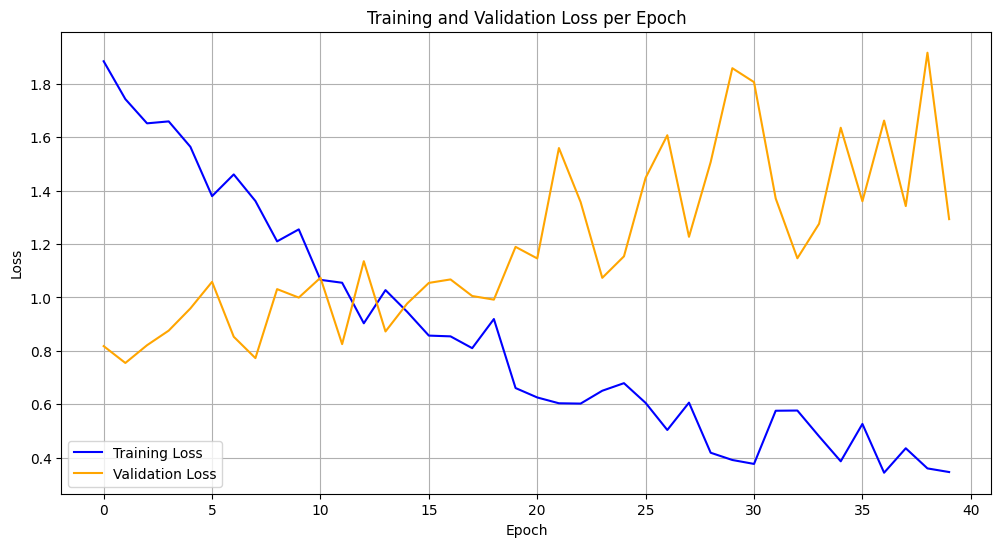

In [42]:
train_model(CNNLSTM2, output_layers=32, kernel_size=3, dropout_rate=0.2, learning_rate=0.01, batch_size=32, num_epoch=40)


# MACHINE NOT LEARNINGGGGG :(

### Hyperparameter Tuning

In [ ]:
search = {
    'output_layers': [16, 32, 64],
    'kernel_size': [3, 5, 7],
    'dropout_rate': [0.2, 0.5, 0.7],
    'learning_rate': [0.01, 0.005, 0.001, 0.0001],
    'batch_size': [16, 32, 64, 128]
}